<a href="https://colab.research.google.com/github/Anupam-USP/Oral-Cancer-Detection/blob/main/Binary_class/DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import imgaug as ia
from imgaug import augmenters as iaa

In [ ]:
train_dir='/content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Train'
validation_dir='/content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Val'
train_cancer=os.path.join(train_dir,'Cancer')
train_noncancer=os.path.join(train_dir,'Non-Cancer')
val_cancer=os.path.join(validation_dir,'Cancer')
val_noncancer=os.path.join(validation_dir,'Non-Cancer')

In [ ]:
train_c=os.listdir(train_cancer)
train_nc=os.listdir(train_noncancer)
val_c=os.listdir(val_cancer)
val_nc=os.listdir(val_noncancer)

print(len(train_c))
print(len(train_nc))
print(len(val_c))
print(len(val_nc))

95
185
31
63


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [ ]:
def build_model():
  base_model = DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-3]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.SGD()

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

  model.summary()
  
  return model

In [ ]:
model=build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=4,epochs=20,verbose=1,validation_data = validation_generator,validation_steps=4)

Epoch 1/20
4/4 [==============================] - 19s 1s/step - loss: 0.7194 - accuracy: 0.6750 - val_loss: 0.5683 - val_accuracy: 0.7250
Epoch 2/20
4/4 [==============================] - 1s 408ms/step - loss: 0.5900 - accuracy: 0.7750 - val_loss: 0.5578 - val_accuracy: 0.7250
Epoch 3/20
4/4 [==============================] - 2s 443ms/step - loss: 0.4999 - accuracy: 0.7750 - val_loss: 0.5982 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 2s 444ms/step - loss: 0.5247 - accuracy: 0.7750 - val_loss: 0.5500 - val_accuracy: 0.7750
Epoch 5/20
4/4 [==============================] - 2s 485ms/step - loss: 0.2761 - accuracy: 0.9500 - val_loss: 0.2780 - val_accuracy: 0.9250
Epoch 6/20
4/4 [==============================] - 1s 426ms/step - loss: 0.3373 - accuracy: 0.8500 - val_loss: 1.3870 - val_accuracy: 0.4500
Epoch 7/20
4/4 [==============================] - 1s 406ms/step - loss: 0.2790 - accuracy: 0.9250 - val_loss: 0.3607 - val_accuracy: 0.8750
Epoch 8/20
4/4 [======

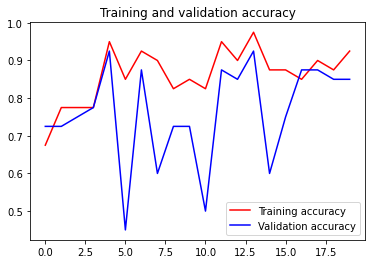

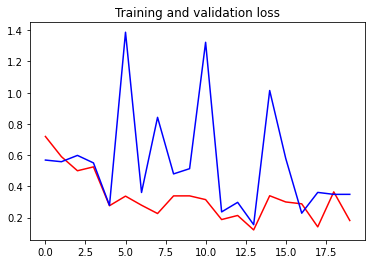

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.show()

In [ ]:
def Group_Conv(tensor,channels,groups):
  input_ch=tensor.get_shape().as_list()[-1]
  group_ch=input_ch//groups
  output_ch=channels//groups
  groups_list=[]
  for i in range(groups):
    group_tensor=Lambda(lambda x : x[:,:,:,(i*group_ch):(i+1)*group_ch])(tensor)
    group_tensor=Conv2D(output_ch,1)(group_tensor)
    groups_list.append(group_tensor)
  output=Concatenate()(groups_list)
  return output

def channel_shuffle(x,groups):
  _,width,height,channels=x.get_shape().as_list()
  group_ch=channels//groups
  x=Reshape([width,height,group_ch,groups])(x)
  x=Permute([1,2,4,3])(x)
  x=Reshape([width,height,channels])(x)
  return x
class shufflenet_block(Model):
  def __init__(self,channels,strides,groups):
    super(shufflenet_block,self).__init__()
    self.channels=channels
    self.strides=strides
    self.groups=groups
    self.relu1=ReLU()
    self.relu2=ReLU()
    self.dconv=DepthwiseConv2D(3,strides=strides,padding='same')                            
    self.bn1=BatchNormalization()
    self.bn2=BatchNormalization()
    self.bn3=BatchNormalization()
    self.add=Add()
    self.avg=AvgPool2D(3,strides=2,padding='same')
    self.concat=Concatenate()
  
  def call(self,inputs):
    x=Group_Conv(tensor=inputs,channels=self.channels//4,groups=self.groups)
    x=self.bn1(x)
    x=self.relu1(x)
    x=channel_shuffle(x=x,groups=self.groups)
    x=self.dconv(x)
    x=self.bn2(x)
    if self.strides==2:
      self.channels=self.channels-inputs.get_shape().as_list()[-1]
    x=Group_Conv(tensor=x,channels=self.channels,groups=self.groups)
    x=self.bn3(x)
    if self.strides==1:
      x=self.add([inputs,x])
    else:
      avg=self.avg(inputs)
      x=self.concat([avg,x])
    x=self.relu2(x)
    return x
class Stage(Model):
  def __init__(self,channels,repetitions,groups):
    super(Stage,self).__init__()
    self.channels=channels
    self.repetitions=repetitions
    self.groups=groups
    self.shufflenet_block1 = shufflenet_block(channels=channels,strides=1,groups=groups)
    self.shufflenet_block2 = shufflenet_block(channels=channels,strides=2,groups=groups)

  def call(self,inputs):
    x = self.shufflenet_block1(inputs)
    for _ in range(self.repetitions):
      x=self.shufflenet_block2(x)
    return x
# repetitions=3,groups=8,channels=384
# repetitions=7,groups=8,channels=384*2
# repetitions=3,groups=8,channels=384*4
class ShuffleNet(Model):
  def __init__(self,classes=2):
    super(ShuffleNet,self).__init__()
    self.classes=classes
    self.conv2d=Conv2D(24,3,strides=2,padding='same')
    self.bn=BatchNormalization()
    self.relu=ReLU()
    self.maxpool=MaxPool2D(3,strides=2,padding='same')
    self.stage1=Stage(repetitions=3,groups=8,channels=384)
    self.stage2=Stage(repetitions=7,groups=8,channels=384*2)
    self.stage3=Stage(repetitions=3,groups=8,channels=384*4)
    self.globalavgpool=GlobalAvgPool2D()
    self.dense=Dense(self.classes,activation='softmax')
  def call(self,inputs):
    x=self.conv2d(inputs)
    x=self.bn(x)
    x=self.relu(x)
    x=self.maxpool(x)
    x=self.stage1(x)
    x=self.stage2(x)
    x=self.stage3(x)
    x=self.globalavgpool(x)
    output=self.dense()(x)
    return output
